In [7]:
# import the packages to download and use datasets from huggingface
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer

In [8]:
# get the first three elements of the huggingface dataset "hate_speech_offensive" and print them
dataset = load_dataset("hate_speech_offensive")
dataset["train"][:3]

Using custom data configuration default
Found cached dataset hate_speech_offensive (C:/Users/tobia/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5)


  0%|          | 0/1 [00:00<?, ?it/s]

{'count': [3, 3, 3],
 'hate_speech_count': [0, 0, 0],
 'offensive_language_count': [0, 3, 3],
 'neither_count': [3, 0, 0],
 'class': [2, 1, 1],
 'tweet': ["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
  '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!',
  '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit']}

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})

In [ ]:
# finetune the transformer model with a trainer and optimizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import AdamW

In [ ]:
# load the model
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# optimizer and training arguments
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir="results",          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir="logs",            # directory for storing logs
    logging_steps=10,
)

In [ ]:
# compute metric
import numpy as np
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# define the trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset["train"],         # training dataset
    eval_dataset=dataset["test"],           # evaluation dataset
    compute_metrics=compute_metrics         # define metrics function
)

In [ ]:
# train the model
trainer.train()

In [ ]:
# evaluate the model
trainer.evaluate()

In [ ]:
# save the model
trainer.save_model("results")

In [ ]:
# load the model
model = AutoModelForSequenceClassification.from_pretrained("results")

In [ ]:
#############################################

In [44]:
# import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model_name = "facebook/roberta-hate-speech-dynabench-r4-target"

In [3]:
# load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [4]:
# define the pipeline
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [29]:
dataset = load_dataset("hate_speech_offensive")
dataset["train"][:3]

Using custom data configuration default
Found cached dataset hate_speech_offensive (C:/Users/tobia/.cache/huggingface/datasets/hate_speech_offensive/default/1.0.0/5f5dfc7b42b5c650fe30a8c49df90b7dbb9c7a4b3fe43ae2e66fabfea35113f5)


  0%|          | 0/1 [00:00<?, ?it/s]

{'count': [3, 3, 3],
 'hate_speech_count': [0, 0, 0],
 'offensive_language_count': [0, 3, 3],
 'neither_count': [3, 0, 0],
 'class': [2, 1, 1],
 'tweet': ["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
  '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!',
  '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit']}

In [51]:
label_names = ["hate", "hate", "nothate"]
lbl_for_plt = ["hate", "nothate"]

In [52]:
dataset_ = dataset["train"][:100]

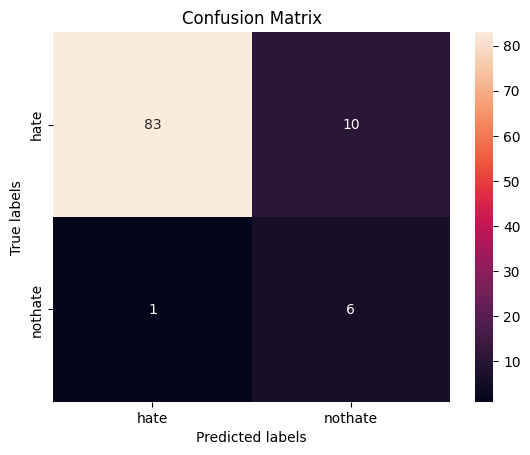

In [53]:
# classify the texts and measure the accuracy
predictions = classifier(dataset_["tweet"])
predictions = [prediction["label"] for prediction in predictions]
accuracy_score([label_names[pred_class] for pred_class in dataset_["class"]], predictions)

cm = confusion_matrix([label_names[pred_class] for pred_class in dataset_["class"]], predictions)
# set axis labels for confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="d")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(lbl_for_plt)
ax.yaxis.set_ticklabels(lbl_for_plt)
plt.show()